In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

import tensorflow as tf
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (10,6)

# Data Preprocessing:

In [4]:
file = './data/surrModel_trainingDB_uF0_PS1_ss100k.pkl'
with open(file, 'rb') as f:
    train_data = pickle.load(f)
training_in = train_data['input']
training_out = train_data['output']

In [5]:
input_names = {}
input_names_raw = training_in.keys().to_list()

output_names = {}
output_names_raw = training_out.keys().to_list()

input_names['demand'] = [name_i for name_i in input_names_raw if name_i.startswith('J')]
input_names['pumps'] = [name_i for name_i in input_names_raw if name_i.startswith('PU')]
input_names['valves'] = [name_i for name_i in input_names_raw if name_i.startswith('V')]
input_names['tanks'] = [name_i for name_i in input_names_raw if name_i.startswith('T')]

output_names['pressure'] = [name_i for name_i in output_names_raw if name_i.startswith('J')]
output_names['tanks'] = [name_i for name_i in output_names_raw if name_i.startswith('T')]
output_names['power'] = [name_i for name_i in output_names_raw if name_i.startswith('PU')]

## Check Data and filter

``data_filter`` holds a ``bool`` for every entry of the data matrices. It is set to zero if any of the conditions are not satisfied. All data is filtered in the end to exclude faulty values.

In [6]:
data_filter = np.ones(training_in.shape[0], dtype=bool)

### Junctions:
Pressure and demand.

In [7]:
junction_demand = training_in[input_names['demand']]
junction_pressure = training_out[output_names['pressure']]

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

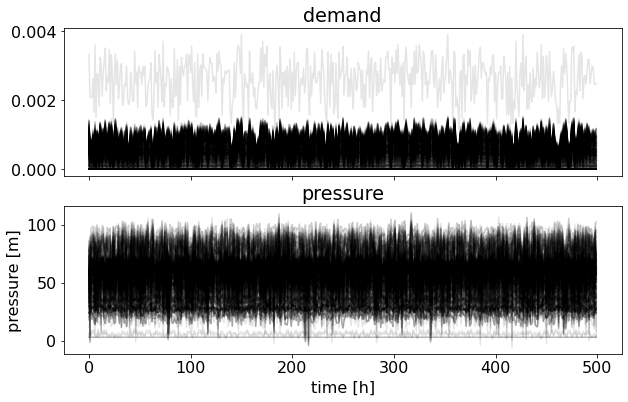

In [8]:
fig, ax = plt.subplots(2,1, sharex=True)
junction_demand.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='demand', xlabel='time [h]')
junction_pressure.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

In [9]:
#data_filter = data_filter & np.all(np.abs(junction_pressure)<1e3, axis=1)
#data_filter = data_filter & np.all(junction_pressure>0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

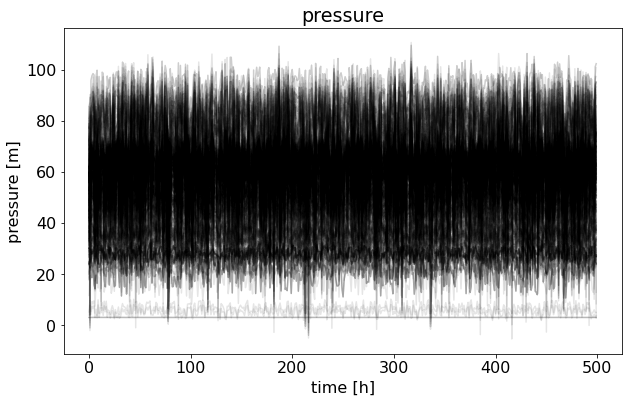

In [10]:
junction_pressure[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

### Tank levels:

<AxesSubplot:title={'center':'next tank levels'}, xlabel='time [h]', ylabel='delta height [m]'>

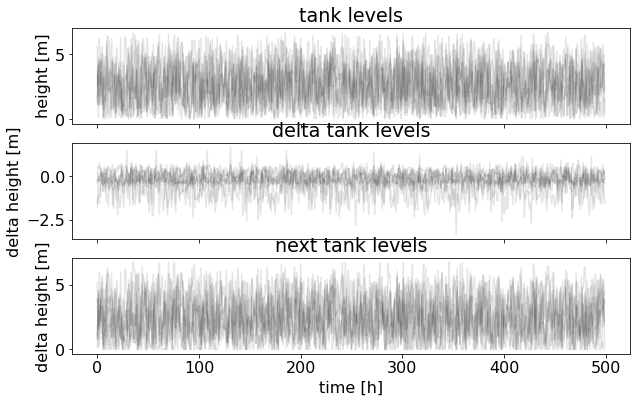

In [11]:
fig, ax = plt.subplots(3,1, sharex = True)
tank_level = training_in[input_names['tanks']]
dtank_level = training_out[output_names['tanks']]
dtank_level.columns = tank_level.columns
tank_level_next = tank_level+dtank_level
tank_level.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='tank levels', xlabel='time [h]', ylabel='height [m]')
dtank_level.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='delta tank levels', xlabel='time [h]', ylabel='delta height [m]')
tank_level_next.head(500).plot(ax=ax[2],legend=False, color='k', alpha=0.1, title='next tank levels', xlabel='time [h]', ylabel='delta height [m]')

In [12]:
100*(tank_level_next.mean()-tank_level.mean())/tank_level.mean()

T3    -1.690607
T1    -8.239207
T7   -27.415509
T6    -2.852221
T5    -8.000860
T2     7.004937
T4   -30.743406
dtype: float64

### Pumps:

<AxesSubplot:title={'center':'pump setting'}, xlabel='time [h]', ylabel='setting'>

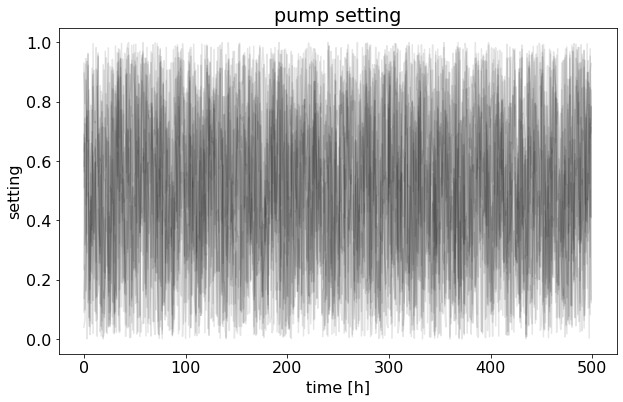

In [13]:
pump_setting = training_in[input_names['pumps']]
pump_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='pump setting', xlabel='time [h]', ylabel='setting')

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

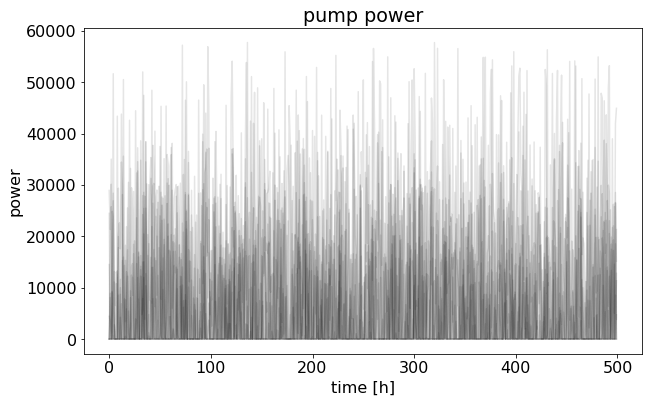

In [14]:
pump_power = training_out[output_names['power']]
pump_power.head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

In [15]:
#data_filter = data_filter & np.all(np.abs(pump_power)<1e6,axis=1) & np.all(pump_power>=0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

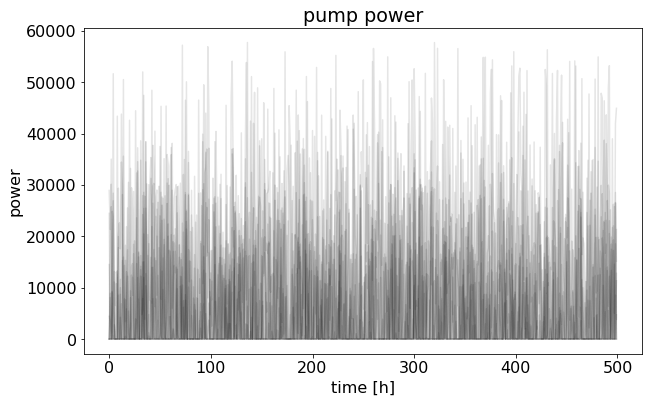

In [16]:
pump_power[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

Let's check the pump_power vs pump_setting after filtering:

Text(0.5, 1.0, 'pump setting vs. power consumption')

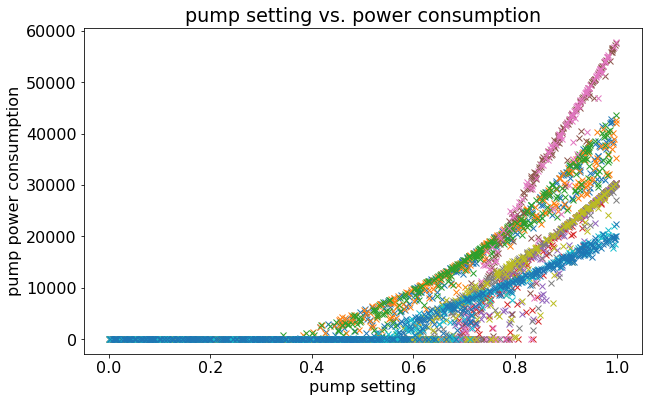

In [17]:
fig, ax = plt.subplots()
ax.plot(pump_setting[data_filter].head(500).to_numpy(), pump_power[data_filter].head(500).to_numpy(), 'x')
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power consumption')
ax.set_title('pump setting vs. power consumption')

### Valves

<AxesSubplot:title={'center':'valve settting'}, xlabel='time [h]', ylabel='setting'>

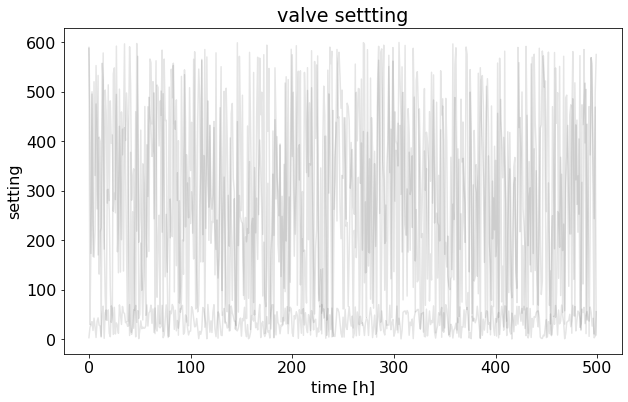

In [18]:
valve_setting = training_in[input_names['valves']]

valve_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='valve settting', xlabel='time [h]', ylabel='setting')

## Neural Network Pre-Processing
### NN inputs:

In [91]:
input_1_dict = {
    'junction_demand': junction_demand[data_filter]
}
nn_inputs_1 = pd.concat(input_1_dict.values(), axis=1, keys=input_1_dict.keys())

input_2_dict = {
    'tank_level': tank_level[data_filter],
}
nn_inputs_2 = pd.concat(input_2_dict.values(), axis=1, keys=input_2_dict.keys())

input_3_dict = {
    'pump_setting': pump_setting[data_filter],                   
    'valve_setting': valve_setting[data_filter]
}
nn_inputs_3 = pd.concat(input_3_dict.values(), axis=1, keys=input_3_dict.keys())

nn_input_dict = {
    'demand': nn_inputs_1,
    'states': nn_inputs_2,
    'inputs': nn_inputs_3,
}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

nn_input.head(2)

demand                                                            \
  junction_demand                                                             
           J511_d    J411_d    J414_d J415_d J416_d    J417_d J418_d J419_d   
0        0.000929  0.000762  0.000828    0.0    0.0  0.001107    0.0    0.0   
1        0.000587  0.000412  0.000447    0.0    0.0  0.000598    0.0    0.0   

                       ...       inputs                                \
                       ... pump_setting                                 
     J310_d    J311_d  ...          PU5       PU6       PU7       PU8   
0  0.001048  0.000913  ...     0.234480  0.040475  0.511187  0.564586   
1  0.000725  0.000631  ...     0.725745  0.064877  0.660430  0.889907   

                                                                      
                                valve_setting                         
        PU9      PU10      PU11           V45         V47         V2  
0  0.929807  0.583212  0.632190    589.815644  587.652053   2.766015  
1  0.098324  0.745180  0.679041    449.815104   29.166241  23.221929  

[2 rows x 409 columns]

### NN outputs:

In [92]:
output_1_dict ={
    'junction_pressure': junction_pressure[data_filter],
}
nn_outputs_1 = pd.concat(output_1_dict.values(), axis=1, keys=output_1_dict.keys())

output_2_dict = {
    'pump_power': pump_power[data_filter],
}
nn_outputs_2 = pd.concat(output_2_dict.values(), axis=1, keys=output_2_dict.keys())

output_3_dict = {
    'tank_level': dtank_level[data_filter],
    #'tank_level': tank_level_next[data_filter]
}
nn_outputs_3 = pd.concat(output_3_dict.values(), axis=1, keys=output_3_dict.keys())

nn_output_dict = {
    'pressure': nn_outputs_1,
    'energy': nn_outputs_2,
    'dstates': nn_outputs_3,
}
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

nn_output.head(2)

pressure                                                         \
  junction_pressure                                                          
             J511_p     J411_p     J414_p     J415_p     J416_p     J417_p   
0         28.516209  63.541023  36.594948  58.643337  81.043335  33.113400   
1         31.023098  65.504532  38.143955  66.849159  89.249161  34.497074   

                                               ...        energy               \
                                               ...    pump_power                
      J418_p     J419_p     J310_p     J311_p  ...         PU9_P       PU10_P   
0  32.755207  29.097137  48.912586  44.836769  ...  24463.834489     0.000000   
1  32.570992  28.920317  54.977676  50.884941  ...      0.000000  8904.443241   

                  dstates                                                    \
               tank_level                                                     
        PU11_P         T3        T1        T7        T6        T5        T2   
0  4406.649493  -0.414477 -0.194584 -1.587196 -0.258440  0.167841  0.520759   
1  3395.104302   0.031338 -0.311106 -0.220377  0.170594  0.423695  0.488421   

             
             
         T4  
0 -1.789435  
1 -1.130805  

[2 rows x 406 columns]

Filter inputs and outputs. Due to shifting, we introduced `NaN` in the dataframes. These are removed in this step.

In [93]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]
    

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input.shape, nn_output.shape[1]))

n_samples=100000, n_inputs = 409, n_outputs=406


Split into test and train set:

In [94]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = train_test_split(
    nn_input, nn_output, test_size = 0.1
)

In [95]:
input_scaling = nn_input_train.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_train_scaled = nn_input_train/input_scaling
nn_input_test_scaled = nn_input_test/input_scaling

output_scaling = nn_output_train.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_train_scaled = nn_output_train/output_scaling
nn_output_test_scaled = nn_output_test/output_scaling

# DNN Model creation

Create model architecture with input to condense the demand and then input for states control inputs etc.

In [96]:
UnitNorm_cons = tf.keras.constraints.UnitNorm(axis=1)
minmax_cons = tf.keras.constraints.MinMaxNorm(
    min_value=0, max_value=1.0, rate=1.0, axis=1
)
nonneg_cons = tf.keras.constraints.NonNeg()
unitnorm_cons = tf.keras.constraints.UnitNorm(
    axis=1
)

l1_penalty = tf.keras.regularizers.l1(l=0.0001)
l2_penalty = tf.keras.regularizers.l2(l=0.01)

In [97]:
n_cluster = 30
n_layer = 3
n_neurons_per_layer = 50

# Input 1 with reduction:
tf_in_1 = tf.keras.Input(shape=(nn_input['demand'].shape[1]), name='demand_in')

tf_in_1_red = tf.keras.layers.Dense(
    n_cluster, 
    name='cluster_demand', 
    use_bias=True,
    #activation=tf.nn.tanh,
    #kernel_regularizer=l1_penalty,
    #kernel_constraint=UnitNorm_cons,
)(tf_in_1)

# Input 2 & 3
tf_in_2 = tf.keras.Input(shape=(nn_input['states'].shape[1],), name='states_in')
tf_in_3 = tf.keras.Input(shape=(nn_input['inputs'].shape[1],), name='inputs_in')

tf_in_2_scaled = tf_in_2/input_scaling['states']
tf_in_3_scaled = tf_in_3/input_scaling['inputs']

# Concatenating inputs:
tf_in_cat = tf.keras.layers.concatenate([tf_in_1_red, tf_in_2, tf_in_3], name='input_concatenate')

# Intermediate (non-linear) layers:
for i in range(n_layer):
    kernel_regularizer = None
    if i == 0:
        tf_interm = tf.keras.layers.Dense(
            n_neurons_per_layer, 
            activation=tf.nn.tanh, 
            kernel_regularizer = kernel_regularizer,
            name='interm_'+str(i)
        )(tf_in_cat)
    else:
        tf_interm = tf.keras.layers.Dense(
            n_neurons_per_layer, 
            activation=tf.nn.tanh, 
            kernel_regularizer = kernel_regularizer,
            name='interm_'+str(i)
        )(tf_interm)

# splitting:
tf_interm_1 = tf_interm[:,:n_cluster]
tf_interm_2 = tf_interm[:,n_cluster:]

# Linear output layer
tf_out_1 = tf.keras.layers.Dense(
    nn_output['pressure'].shape[1], 
    name='pressure_out', 
    use_bias=False,
    kernel_constraint=nonneg_cons,
    #kernel_constraint = unitnorm_cons,
    #kernel_regularizer = l1_penalty,
)(tf_interm_1)

tf_out_2 = tf.keras.layers.Dense(nn_output['energy'].shape[1], name='energy_out')(tf_interm_2)


tf_out_3 = tf.keras.layers.Dense(
    nn_output['dstates'].shape[1], 
    name='dstates_out',
    #kernel_regularizer = l2_penalty,
)(tf_interm_2)

tf_out_3 = tf.keras.layers.add([tf_out_3, tf_in_2], name='states_out')

In [98]:
model = tf.keras.Model(inputs=[tf_in_1, tf_in_2, tf_in_3], outputs=[tf_out_1,tf_out_2, tf_out_3])

In [99]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='mse')

## Model training

In [100]:
x_subset = nn_input_train_scaled#.head(50000)
y_subset = nn_output_train_scaled#.head(50000)

x_train = [x_subset['demand'], x_subset['states'], x_subset['inputs']]
y_train = [y_subset['pressure'], y_subset['energy'], y_subset['dstates']]
x_test = [nn_input_test_scaled['demand'], nn_input_test_scaled['states'], nn_input_test_scaled['inputs']]
y_test = [nn_output_test_scaled['pressure'], nn_output_test_scaled['energy'], nn_output_test_scaled['dstates']]

history = model.fit(x_train, y_train,
                    batch_size=5000, 
                    epochs=1500)

Epoch 1/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.7208 - pressure_out_loss: 0.3179 - energy_out_loss: 0.1208 - states_out_loss: 0.2822
Epoch 2/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.3149 - pressure_out_loss: 0.0258 - energy_out_loss: 0.0828 - states_out_loss: 0.2063
Epoch 3/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.2810 - pressure_out_loss: 0.0077 - energy_out_loss: 0.0781 - states_out_loss: 0.1952
Epoch 4/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.2624 - pressure_out_loss: 0.0051 - energy_out_loss: 0.0762 - states_out_loss: 0.1811
Epoch 5/1500
18/18 [==============================] - 1s 53ms/step - loss: 0.2452 - pressure_out_loss: 0.0048 - energy_out_loss: 0.0746 - states_out_loss: 0.1658
Epoch 6/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.2274 - pressure_out_loss: 0.0049 - energy_out_loss: 0.0733 - states_out_loss: 0.1493
Epoch 7/1500
18/18 [========

18/18 [==============================] - 1s 42ms/step - loss: 0.0625 - pressure_out_loss: 0.0031 - energy_out_loss: 0.0285 - states_out_loss: 0.0309
Epoch 52/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0625 - pressure_out_loss: 0.0031 - energy_out_loss: 0.0283 - states_out_loss: 0.0311
Epoch 53/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0622 - pressure_out_loss: 0.0031 - energy_out_loss: 0.0282 - states_out_loss: 0.0309
Epoch 54/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0619 - pressure_out_loss: 0.0031 - energy_out_loss: 0.0280 - states_out_loss: 0.0308
Epoch 55/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0616 - pressure_out_loss: 0.0030 - energy_out_loss: 0.0279 - states_out_loss: 0.0306
Epoch 56/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0614 - pressure_out_loss: 0.0030 - energy_out_loss: 0.0278 - states_out_loss: 0.0306
Epoch 57/1500
18/18 [===============

18/18 [==============================] - 1s 36ms/step - loss: 0.0490 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0240 - states_out_loss: 0.0227
Epoch 102/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0485 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0238 - states_out_loss: 0.0223
Epoch 103/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0481 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0236 - states_out_loss: 0.0222
Epoch 104/1500
18/18 [==============================] - 1s 49ms/step - loss: 0.0475 - pressure_out_loss: 0.0023 - energy_out_loss: 0.0234 - states_out_loss: 0.0217
Epoch 105/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0472 - pressure_out_loss: 0.0023 - energy_out_loss: 0.0232 - states_out_loss: 0.0217
Epoch 106/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0464 - pressure_out_loss: 0.0023 - energy_out_loss: 0.0230 - states_out_loss: 0.0211
Epoch 107/1500
18/18 [=========

18/18 [==============================] - 1s 37ms/step - loss: 0.0223 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0093 - states_out_loss: 0.0111
Epoch 152/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0222 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0092 - states_out_loss: 0.0111
Epoch 153/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0217 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0090 - states_out_loss: 0.0108
Epoch 154/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0215 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0087 - states_out_loss: 0.0109
Epoch 155/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0216 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0087 - states_out_loss: 0.0110
Epoch 156/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0208 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0083 - states_out_loss: 0.0106
Epoch 157/1500
18/18 [=========

18/18 [==============================] - 1s 40ms/step - loss: 0.0143 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0046 - states_out_loss: 0.0081
Epoch 202/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0141 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0044 - states_out_loss: 0.0080
Epoch 203/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0139 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0044 - states_out_loss: 0.0080
Epoch 204/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0141 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0045 - states_out_loss: 0.0080
Epoch 205/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0140 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0043 - states_out_loss: 0.0081
Epoch 206/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0138 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0043 - states_out_loss: 0.0079
Epoch 207/1500
18/18 [=========

18/18 [==============================] - 1s 35ms/step - loss: 0.0113 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0029 - states_out_loss: 0.0069
Epoch 252/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0114 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0029 - states_out_loss: 0.0070
Epoch 253/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0114 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0029 - states_out_loss: 0.0070
Epoch 254/1500
18/18 [==============================] - 1s 51ms/step - loss: 0.0113 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0029 - states_out_loss: 0.0069
Epoch 255/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0113 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0029 - states_out_loss: 0.0070
Epoch 256/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0113 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0029 - states_out_loss: 0.0069
Epoch 257/1500
18/18 [=========

18/18 [==============================] - 1s 35ms/step - loss: 0.0104 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0027 - states_out_loss: 0.0063
Epoch 302/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0103 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0026 - states_out_loss: 0.0063
Epoch 303/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0103 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0026 - states_out_loss: 0.0063
Epoch 304/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0102 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0026 - states_out_loss: 0.0062
Epoch 305/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0102 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0026 - states_out_loss: 0.0062
Epoch 306/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0104 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0026 - states_out_loss: 0.0064
Epoch 307/1500
18/18 [=========

18/18 [==============================] - 1s 35ms/step - loss: 0.0096 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0024 - states_out_loss: 0.0058
Epoch 352/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0095 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0024 - states_out_loss: 0.0058
Epoch 353/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0094 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0023 - states_out_loss: 0.0057
Epoch 354/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0094 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0023 - states_out_loss: 0.0058
Epoch 355/1500
18/18 [==============================] - 1s 44ms/step - loss: 0.0096 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0024 - states_out_loss: 0.0058
Epoch 356/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0094 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0023 - states_out_loss: 0.0058
Epoch 357/1500
18/18 [=========

18/18 [==============================] - 1s 35ms/step - loss: 0.0088 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0021 - states_out_loss: 0.0054
Epoch 402/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0088 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0022 - states_out_loss: 0.0054
Epoch 403/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0088 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0022 - states_out_loss: 0.0054
Epoch 404/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0087 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0021 - states_out_loss: 0.0053
Epoch 405/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0087 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0021 - states_out_loss: 0.0053
Epoch 406/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0088 - pressure_out_loss: 0.0013 - energy_out_loss: 0.0022 - states_out_loss: 0.0054
Epoch 407/1500
18/18 [=========

18/18 [==============================] - 1s 35ms/step - loss: 0.0085 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0021 - states_out_loss: 0.0052
Epoch 452/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0083 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0020 - states_out_loss: 0.0051
Epoch 453/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0083 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0020 - states_out_loss: 0.0050
Epoch 454/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0084 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0021 - states_out_loss: 0.0052
Epoch 455/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0083 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0020 - states_out_loss: 0.0051
Epoch 456/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0082 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0020 - states_out_loss: 0.0050
Epoch 457/1500
18/18 [=========

18/18 [==============================] - 1s 35ms/step - loss: 0.0079 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0019 - states_out_loss: 0.0048
Epoch 502/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0079 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0019 - states_out_loss: 0.0048
Epoch 503/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0079 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0019 - states_out_loss: 0.0048
Epoch 504/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0078 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0019 - states_out_loss: 0.0048
Epoch 505/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0078 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0019 - states_out_loss: 0.0048
Epoch 506/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0079 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0019 - states_out_loss: 0.0048
Epoch 507/1500
18/18 [=========

18/18 [==============================] - 1s 41ms/step - loss: 0.0076 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 0.0046
Epoch 552/1500
18/18 [==============================] - 1s 43ms/step - loss: 0.0076 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 0.0046
Epoch 553/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0076 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 0.0046
Epoch 554/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0076 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 0.0046
Epoch 555/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0076 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 0.0046
Epoch 556/1500
18/18 [==============================] - 1s 43ms/step - loss: 0.0076 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0018 - states_out_loss: 0.0046
Epoch 557/1500
18/18 [=========

18/18 [==============================] - 1s 37ms/step - loss: 0.0073 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 0.0045
Epoch 602/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0073 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 0.0045
Epoch 603/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0073 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 0.0044
Epoch 604/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0074 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 0.0045
Epoch 605/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0074 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 0.0045
Epoch 606/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0073 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0017 - states_out_loss: 0.0045
Epoch 607/1500
18/18 [=========

18/18 [==============================] - 1s 37ms/step - loss: 0.0071 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0043
Epoch 652/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0071 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0043
Epoch 653/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0071 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0043
Epoch 654/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0071 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0043
Epoch 655/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0071 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0043
Epoch 656/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0071 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0043
Epoch 657/1500
18/18 [=========

18/18 [==============================] - 1s 37ms/step - loss: 0.0068 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0041
Epoch 702/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0069 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0041
Epoch 703/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0069 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0041
Epoch 704/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0069 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0041
Epoch 705/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0069 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0016 - states_out_loss: 0.0041
Epoch 706/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0069 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0041
Epoch 707/1500
18/18 [=========

18/18 [==============================] - 1s 35ms/step - loss: 0.0066 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0039
Epoch 752/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0066 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0039
Epoch 753/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0066 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0040
Epoch 754/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0066 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0040
Epoch 755/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0067 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0040
Epoch 756/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0066 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0040
Epoch 757/1500
18/18 [=========

18/18 [==============================] - 1s 37ms/step - loss: 0.0065 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0038
Epoch 802/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0064 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0014 - states_out_loss: 0.0038
Epoch 803/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0064 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0014 - states_out_loss: 0.0038
Epoch 804/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0064 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0014 - states_out_loss: 0.0038
Epoch 805/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0064 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0038
Epoch 806/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0065 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0038
Epoch 807/1500
18/18 [=========

18/18 [==============================] - 1s 35ms/step - loss: 0.0062 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0014 - states_out_loss: 0.0036
Epoch 852/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0062 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0014 - states_out_loss: 0.0036
Epoch 853/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0062 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0014 - states_out_loss: 0.0036
Epoch 854/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0062 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0014 - states_out_loss: 0.0036
Epoch 855/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0063 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0015 - states_out_loss: 0.0036
Epoch 856/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0062 - pressure_out_loss: 0.0012 - energy_out_loss: 0.0014 - states_out_loss: 0.0036
Epoch 857/1500
18/18 [=========

18/18 [==============================] - 1s 37ms/step - loss: 0.0060 - pressure_out_loss: 0.0011 - energy_out_loss: 0.0014 - states_out_loss: 0.0034
Epoch 902/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0061 - pressure_out_loss: 0.0011 - energy_out_loss: 0.0014 - states_out_loss: 0.0035
Epoch 903/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0060 - pressure_out_loss: 0.0011 - energy_out_loss: 0.0014 - states_out_loss: 0.0034
Epoch 904/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0059 - pressure_out_loss: 0.0011 - energy_out_loss: 0.0014 - states_out_loss: 0.0034
Epoch 905/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0059 - pressure_out_loss: 0.0011 - energy_out_loss: 0.0014 - states_out_loss: 0.0034
Epoch 906/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0060 - pressure_out_loss: 0.0011 - energy_out_loss: 0.0014 - states_out_loss: 0.0034
Epoch 907/1500
18/18 [=========

18/18 [==============================] - 1s 38ms/step - loss: 0.0057 - pressure_out_loss: 0.0010 - energy_out_loss: 0.0014 - states_out_loss: 0.0033
Epoch 952/1500
18/18 [==============================] - 1s 46ms/step - loss: 0.0057 - pressure_out_loss: 0.0010 - energy_out_loss: 0.0014 - states_out_loss: 0.0033
Epoch 953/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0057 - pressure_out_loss: 0.0010 - energy_out_loss: 0.0014 - states_out_loss: 0.0033
Epoch 954/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0057 - pressure_out_loss: 0.0010 - energy_out_loss: 0.0014 - states_out_loss: 0.0033
Epoch 955/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0057 - pressure_out_loss: 0.0010 - energy_out_loss: 0.0014 - states_out_loss: 0.0033
Epoch 956/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0057 - pressure_out_loss: 0.0010 - energy_out_loss: 0.0014 - states_out_loss: 0.0033
Epoch 957/1500
18/18 [=========

18/18 [==============================] - 1s 46ms/step - loss: 0.0055 - pressure_out_loss: 9.1609e-04 - energy_out_loss: 0.0014 - states_out_loss: 0.0032
Epoch 1001/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0055 - pressure_out_loss: 9.0318e-04 - energy_out_loss: 0.0014 - states_out_loss: 0.0032
Epoch 1002/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0055 - pressure_out_loss: 9.0218e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0032
Epoch 1003/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0056 - pressure_out_loss: 9.0751e-04 - energy_out_loss: 0.0014 - states_out_loss: 0.0033
Epoch 1004/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0055 - pressure_out_loss: 9.0162e-04 - energy_out_loss: 0.0014 - states_out_loss: 0.0032
Epoch 1005/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0056 - pressure_out_loss: 9.0367e-04 - energy_out_loss: 0.0014 - states_out_loss: 0.0033
Ep

18/18 [==============================] - 1s 36ms/step - loss: 0.0054 - pressure_out_loss: 8.6691e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0032
Epoch 1049/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0054 - pressure_out_loss: 8.5821e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0032
Epoch 1050/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0054 - pressure_out_loss: 8.5692e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0032
Epoch 1051/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0053 - pressure_out_loss: 8.5609e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0032
Epoch 1052/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0054 - pressure_out_loss: 8.5746e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0032
Epoch 1053/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0054 - pressure_out_loss: 8.5579e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0032
Ep

18/18 [==============================] - 1s 36ms/step - loss: 0.0052 - pressure_out_loss: 8.2685e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0031
Epoch 1097/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0052 - pressure_out_loss: 8.2552e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0031
Epoch 1098/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0052 - pressure_out_loss: 8.2622e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0031
Epoch 1099/1500
18/18 [==============================] - 1s 39ms/step - loss: 0.0052 - pressure_out_loss: 8.2590e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0031
Epoch 1100/1500
18/18 [==============================] - 1s 44ms/step - loss: 0.0053 - pressure_out_loss: 8.3399e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0031
Epoch 1101/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0052 - pressure_out_loss: 8.2834e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0031
Ep

18/18 [==============================] - 1s 38ms/step - loss: 0.0051 - pressure_out_loss: 8.1383e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0030
Epoch 1145/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0051 - pressure_out_loss: 8.1366e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0030
Epoch 1146/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0051 - pressure_out_loss: 8.1327e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0030
Epoch 1147/1500
18/18 [==============================] - 1s 42ms/step - loss: 0.0051 - pressure_out_loss: 8.1390e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0031
Epoch 1148/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0051 - pressure_out_loss: 8.1837e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0030
Epoch 1149/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0051 - pressure_out_loss: 8.1537e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0030
Ep

18/18 [==============================] - 1s 40ms/step - loss: 0.0050 - pressure_out_loss: 8.0358e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0030
Epoch 1193/1500
18/18 [==============================] - 1s 40ms/step - loss: 0.0051 - pressure_out_loss: 8.1120e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0030
Epoch 1194/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0051 - pressure_out_loss: 8.0810e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0030
Epoch 1195/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0050 - pressure_out_loss: 8.0599e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0030
Epoch 1196/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0050 - pressure_out_loss: 8.0969e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0030
Epoch 1197/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0050 - pressure_out_loss: 8.0370e-04 - energy_out_loss: 0.0013 - states_out_loss: 0.0029
Ep

18/18 [==============================] - 1s 38ms/step - loss: 0.0050 - pressure_out_loss: 8.0021e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Epoch 1241/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0050 - pressure_out_loss: 7.9730e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Epoch 1242/1500
18/18 [==============================] - 1s 37ms/step - loss: 0.0050 - pressure_out_loss: 7.9943e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0030
Epoch 1243/1500
18/18 [==============================] - 1s 41ms/step - loss: 0.0050 - pressure_out_loss: 7.9659e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Epoch 1244/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0050 - pressure_out_loss: 8.0131e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Epoch 1245/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0050 - pressure_out_loss: 8.0047e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Ep

18/18 [==============================] - 1s 37ms/step - loss: 0.0049 - pressure_out_loss: 8.0071e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Epoch 1289/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0049 - pressure_out_loss: 8.0067e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Epoch 1290/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0049 - pressure_out_loss: 7.9606e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Epoch 1291/1500
18/18 [==============================] - 1s 38ms/step - loss: 0.0049 - pressure_out_loss: 7.9300e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Epoch 1292/1500
18/18 [==============================] - 1s 70ms/step - loss: 0.0049 - pressure_out_loss: 7.9803e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Epoch 1293/1500
18/18 [==============================] - 1s 72ms/step - loss: 0.0049 - pressure_out_loss: 7.9621e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Ep

18/18 [==============================] - 1s 34ms/step - loss: 0.0048 - pressure_out_loss: 7.9160e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1337/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0048 - pressure_out_loss: 7.9239e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1338/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0048 - pressure_out_loss: 7.8958e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0029
Epoch 1339/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0048 - pressure_out_loss: 7.9272e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1340/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0048 - pressure_out_loss: 7.8910e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1341/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0048 - pressure_out_loss: 7.9129e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Ep

18/18 [==============================] - 1s 34ms/step - loss: 0.0048 - pressure_out_loss: 7.8660e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1385/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0048 - pressure_out_loss: 7.8590e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1386/1500
18/18 [==============================] - 1s 36ms/step - loss: 0.0048 - pressure_out_loss: 7.8698e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1387/1500
18/18 [==============================] - 1s 35ms/step - loss: 0.0048 - pressure_out_loss: 7.9233e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1388/1500
18/18 [==============================] - 1s 32ms/step - loss: 0.0048 - pressure_out_loss: 7.9015e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1389/1500
18/18 [==============================] - 1s 31ms/step - loss: 0.0048 - pressure_out_loss: 7.9271e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Ep

18/18 [==============================] - 1s 33ms/step - loss: 0.0047 - pressure_out_loss: 7.8146e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1433/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0047 - pressure_out_loss: 7.8383e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1434/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0047 - pressure_out_loss: 7.8259e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1435/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0047 - pressure_out_loss: 7.8479e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1436/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0047 - pressure_out_loss: 7.8326e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1437/1500
18/18 [==============================] - 1s 33ms/step - loss: 0.0047 - pressure_out_loss: 7.8216e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Ep

18/18 [==============================] - 1s 34ms/step - loss: 0.0047 - pressure_out_loss: 7.8014e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1481/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0047 - pressure_out_loss: 7.8080e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0027
Epoch 1482/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0047 - pressure_out_loss: 7.8336e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0027
Epoch 1483/1500
18/18 [==============================] - 1s 32ms/step - loss: 0.0047 - pressure_out_loss: 7.8216e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0028
Epoch 1484/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0046 - pressure_out_loss: 7.7843e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0027
Epoch 1485/1500
18/18 [==============================] - 1s 34ms/step - loss: 0.0047 - pressure_out_loss: 7.7982e-04 - energy_out_loss: 0.0012 - states_out_loss: 0.0027
Ep

In [101]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 635us/step - loss: 0.0067 - pressure_out_loss: 7.8459e-04 - energy_out_loss: 0.0031 - states_out_loss: 0.0028


[0.00668876338750124,
 0.000784588570240885,
 0.0031344308517873287,
 0.002769741928204894]

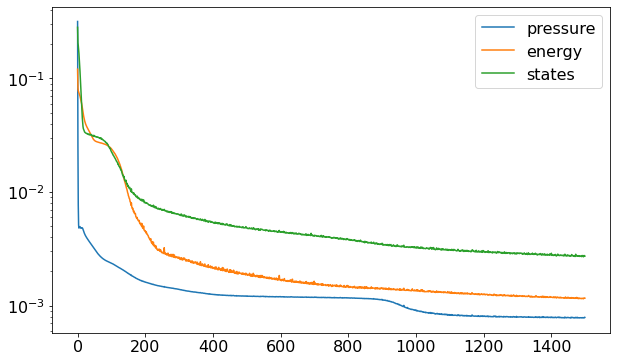

In [102]:
plt.semilogy(history.epoch,history.history['pressure_out_loss'], label='pressure')
plt.semilogy(history.epoch,history.history['energy_out_loss'], label='energy')
plt.semilogy(history.epoch,history.history['states_out_loss'], label='states')
plt.legend()

In [103]:
A_cluster = model.get_layer('pressure_out').get_weights()[0]

In [104]:
np.sum(np.abs(A_cluster)<1e-6)

411

In [105]:
np.prod(A_cluster.shape)

11640

# Validation data

In [106]:
file = './validation/surrModel_scenarioDB_ruleBased_altControl2.pkl'
with open(file, 'rb') as f:
    validation = pickle.load(f)

In [107]:
output_names.keys()

dict_keys(['pressure', 'tanks', 'power'])

In [108]:
val_demand = validation['input'][input_names['demand']]
val_states = validation['input'][input_names['tanks']]
val_inputs = validation['input'][input_names['pumps']+input_names['valves']]

val_pressure = validation['output'][output_names['pressure']]
val_energy = validation['output'][output_names['power']]

<AxesSubplot:>

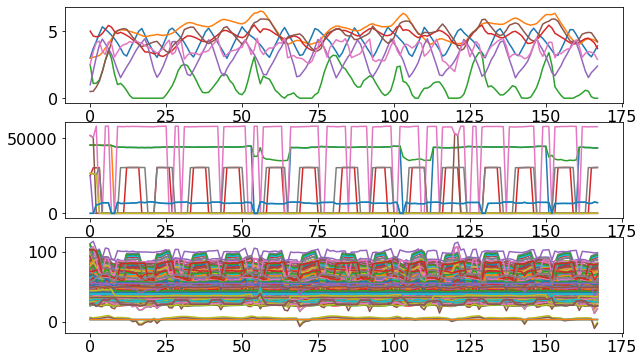

In [109]:
fig,ax = plt.subplots(3,1)
val_states.plot(ax=ax[0], legend=False)
val_energy.plot(ax=ax[1], legend=False)
val_pressure.plot(ax=ax[2], legend=False)

Text(0, 0.5, 'pump power ')

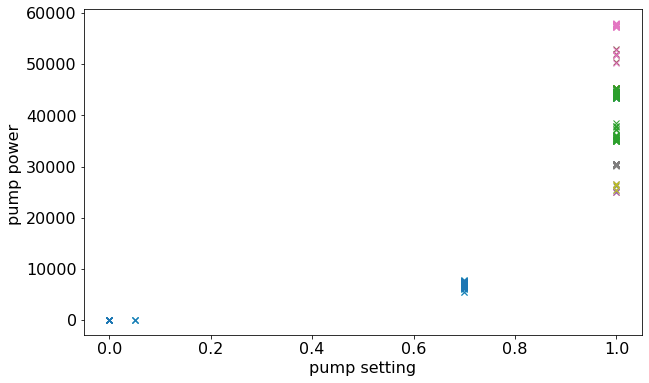

In [110]:
fig, ax = plt.subplots()
ax.plot(
    val_inputs[input_names['pumps']],
    val_energy[output_names['power']],
    'x'
)
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power ')

### Simulation evaluation

In [111]:
from IPython.display import clear_output, display

In [112]:
val_demand_np = val_demand.to_numpy()
val_states_np = val_states.to_numpy()
val_inputs_np = val_inputs.to_numpy()

in_d_scaling = input_scaling['demand'].to_numpy()
in_s_scaling = input_scaling['states'].to_numpy()
in_i_scaling = input_scaling['inputs'].to_numpy()

out_p_scaling = output_scaling['pressure'].to_numpy()
out_e_scaling = output_scaling['energy'].to_numpy()
out_s_scaling = output_scaling['dstates'].to_numpy()

Open loop simulation of the Neural Network

In [114]:
est_states = [val_states_np[[0]]]
est_pressure = []
est_energy = []

for k in range(val_inputs_np.shape[0]-1):
    clear_output(wait=True)
    print(k)
    demand_k = val_demand_np[[k],:]
    states_k = est_states[k]
    inputs_k = val_inputs_np[[k],:]
    
    demand_k_scaled = demand_k/in_d_scaling
    states_k_scaled = states_k/in_s_scaling
    inputs_k_scaled = inputs_k/in_i_scaling

    pressure_scaled, energy_scaled, dstates_scaled = model.predict([demand_k_scaled, states_k_scaled, inputs_k_scaled])
    
    pressure_k = pressure_scaled * out_p_scaling
    energy_k = energy_scaled * out_e_scaling
    states_k_next = states_k + dstates_scaled * out_s_scaling
    #states_k_next = dstates_scaled * out_s_scaling
    
    ### Achtung ENTFERNEN!!!!!!
    #states_k_next = val_states_np[[k+1]]
    #states_k_next = np.minimum(np.maximum(states_k_next,0),6)
    
    est_states.append(states_k_next)
    est_energy.append(energy_k)
    est_pressure.append(pressure_k)

est_pressure = np.concatenate(est_pressure,axis=0)
est_energy = np.concatenate(est_energy,axis=0)
est_states = np.concatenate(est_states,axis=0)

est_pressure_df = pd.DataFrame(data=est_pressure, index=val_pressure.index[:-1], columns=val_pressure.keys())
est_energy_df = pd.DataFrame(data=est_energy, index=val_energy.index[:-1], columns=val_energy.keys())
est_states_df = pd.DataFrame(data=est_states, index=val_states.index, columns=val_states.keys())

166


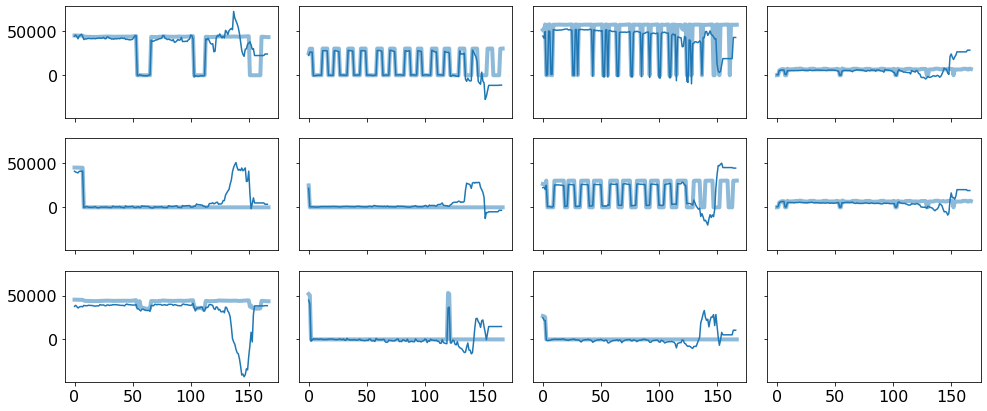

In [115]:
fig,ax = plt.subplots(3,4, figsize=(14,6), sharey=True, sharex=True)

for k,name in enumerate(val_energy.keys()):
    i,j = k%3,k//3
    
    val_energy[name].plot(legend=False, ax=ax[i,j],linewidth=4, alpha=.5)
    ax[i,j].set_prop_cycle(None)
    est_energy_df[name].plot(legend=False, ax=ax[i,j])

fig.tight_layout()
    

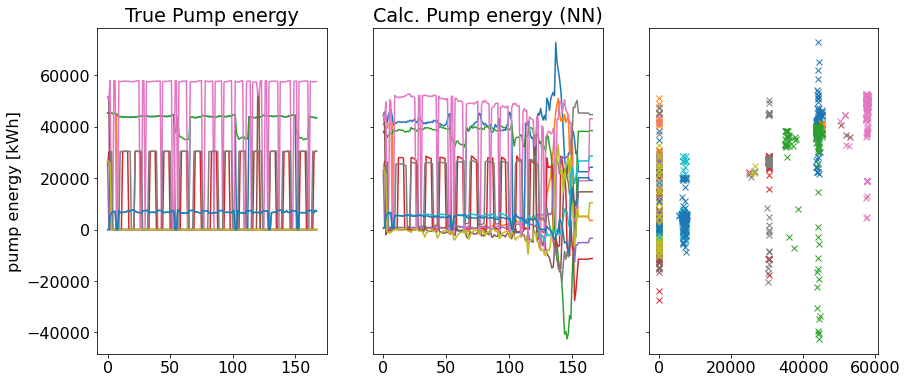

In [116]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_energy.plot(legend=False, ax=ax[0])
ax[1].plot(est_energy)
ax[0].set_title('True Pump energy')
ax[1].set_title('Calc. Pump energy (NN)')
ax[0].set_ylabel('pump energy [kWh]')

ax[2].plot(val_energy.to_numpy()[:-1,:], est_energy, 'x')

plt.show()

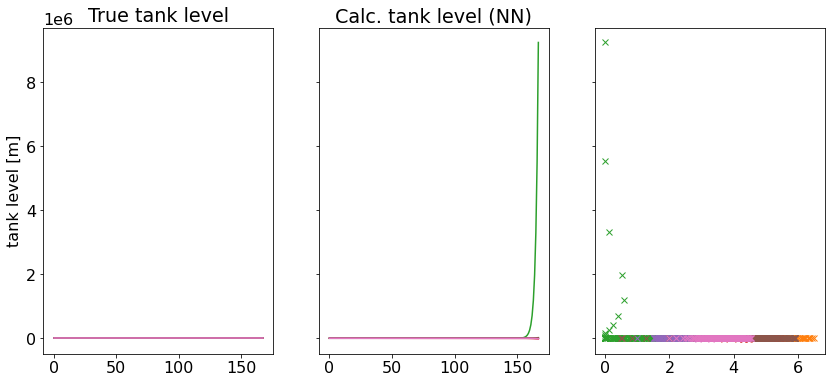

In [117]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.plot(legend=False, ax=ax[0])
ax[1].plot(est_states)
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states,est_states,'x')



plt.show()

In [118]:
est_states.shape

(168, 7)

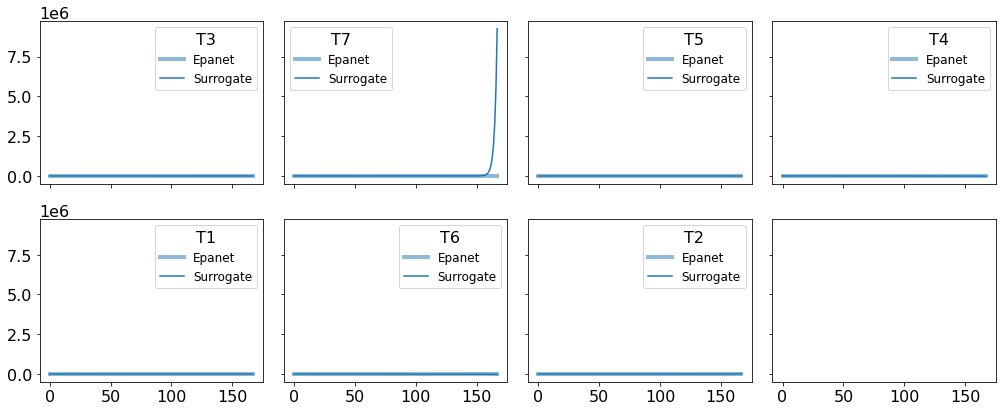

In [119]:
fig,ax = plt.subplots(2,4, figsize=(14,6), sharey=True, sharex=True)

for k,name in enumerate(val_states.keys()):
    i,j = k%2,k//2
    
    val_states[name].plot(ax=ax[i,j],linewidth=4, alpha=.5)
    ax[i,j].set_prop_cycle(None)
    est_states_df[name].plot(ax=ax[i,j])
    ax[i,j].legend(ax[i,j].lines,['Epanet','Surrogate'], title=name, fontsize=12)

fig.tight_layout()

In [79]:
ax[0,0].lines

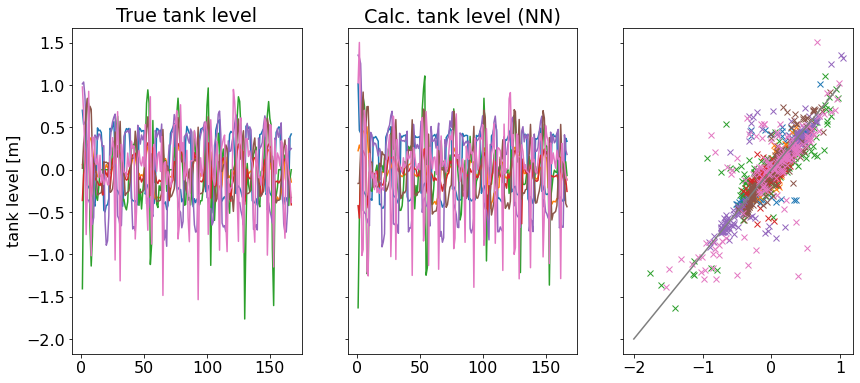

In [80]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.diff().plot(legend=False, ax=ax[0])
est_states_df.diff().plot(legend=False, ax=ax[1])
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states.diff(), est_states_df.diff(),'x')
ax[2].plot([-2,1],[-2,1])

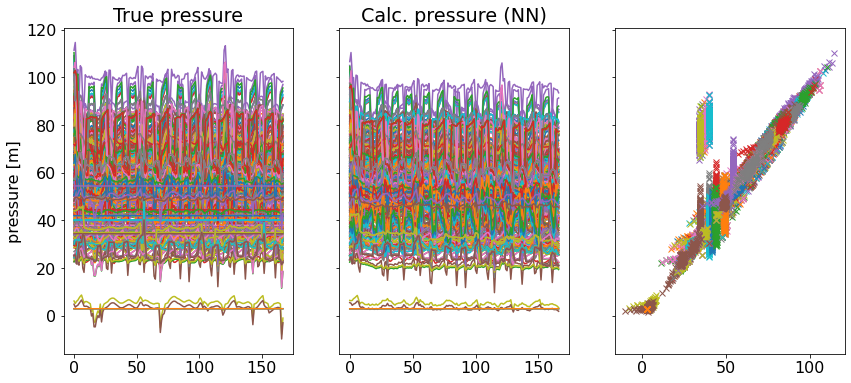

In [81]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_pressure.plot(legend=False, ax=ax[0])
ax[1].plot(est_pressure)
ax[0].set_title('True pressure')
ax[1].set_title('Calc. pressure (NN)')
ax[0].set_ylabel('pressure [m]')
ax[2].plot(val_pressure.to_numpy()[:-1,:],est_pressure, 'x')
plt.show()

Should we save the model?

In [82]:
model_name = '004'
model.save('./keras_models/{name}/{name}_model'.format(name=model_name))
scaling = {
    'input': input_scaling,
    'output': output_scaling
}

with open('./keras_models/{}/scaling.pkl'.format(model_name), 'wb') as f:
    pickle.dump(scaling, f)
    
history_export = history.history
history_export['epoch'] = history.epoch

with open('./keras_models/{}/history.pkl'.format(model_name), 'wb') as f:
    pickle.dump(history_export, f)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./keras_models/004/004_model/assets
